In [16]:
import pandas as pd
import numpy as np
import util
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from matplotlib.lines import Line2D

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import umap
import umap.plot
import seaborn as sns


ROOT_DIR = '../Output/CompareFineGrainedModelsSingleVsMultipleWithSHAPOffice'
models = ['fine_grained_trainedon_Office_m1_242.h5', 'fine_grained_trainedon_ClassroomOffice_m1m2m3_242-fixed.h5']
test_set_string = 'fine_grained/Office/80MHz/3mo/m1/Slots/Test/test_set.csv'

# Constants
activities = {
  'A': 'Push forward',
  'C': 'Hands up and down',
  'P': 'Reading',
  'S': 'Writing'
}

data = {}

for model_index in range(len(models)):
    model = models[model_index]
    data[model_index] = {}
    
    # Load Grad-CAM and embeddings
    saved = np.load(f'{ROOT_DIR}/{model}_gradcam_and_embeddings.npz')
    data[model_index]['gradcam'] = saved['gradcam_heatmaps']
    data[model_index]['embeddings'] = saved['embeddings']
    data[model_index]['shap_gradients'] = saved['shap_gradients_heatmaps']
    data[model_index]['csv'] = pd.read_csv(f'{ROOT_DIR}/{model}_output.csv')
    
    print(f'Loaded data for model {model_index}: {model}')
    print('Grad-CAM shape:', data[model_index]['gradcam'].shape)
    print('Embeddings shape:', data[model_index]['embeddings'].shape)
    print('SHAP Gradients shape:', data[model_index]['shap_gradients'].shape)
    print('CSV shape:', data[model_index]['csv'].shape)   

Loaded data for model 0: fine_grained_trainedon_Office_m1_242.h5
Grad-CAM shape: (6163, 25, 121)
Embeddings shape: (6163, 92928)
SHAP Gradients shape: (6163, 50, 242, 2)
CSV shape: (6163, 6)
Loaded data for model 1: fine_grained_trainedon_ClassroomOffice_m1m2m3_242-fixed.h5
Grad-CAM shape: (6163, 25, 121)
Embeddings shape: (6163, 92928)
SHAP Gradients shape: (6163, 50, 242, 2)
CSV shape: (6163, 6)


----
# Predictions confidence distributions

/tmp/ipykernel_1200280/499193693.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')
/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


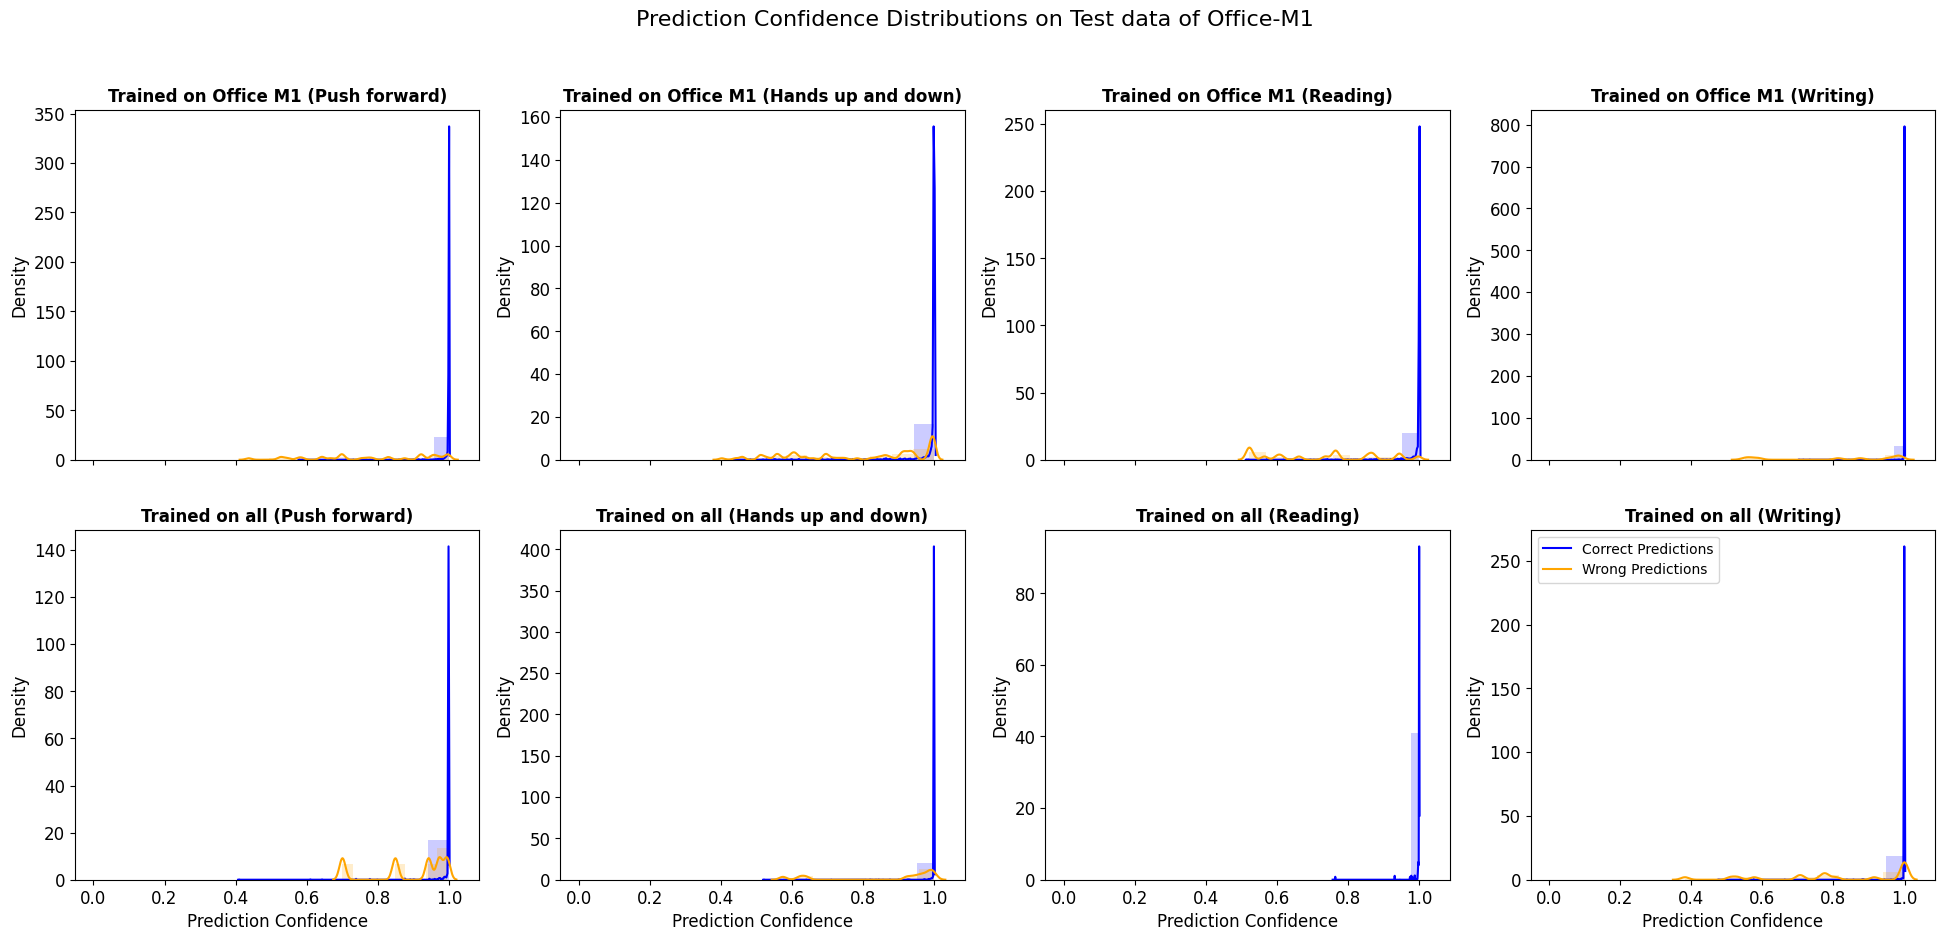

In [19]:
def plot_confidences():
  labels = list(activities.keys())
  labels_english = list(activities.values())
  titles = ['Trained on Office M1', 'Trained on all']
  rows = 2
  cols = 4
  bw = 0.1
  fig, axs = plt.subplots(rows, cols, figsize=(24, 10), sharex=True)
  fig.suptitle('Prediction Confidence Distributions on Test data of Office-M1', fontsize=16)

  for row_index in range(rows):
    for col_index in range(cols):
      title = f'{titles[row_index]} ({labels_english[col_index]})'
      label = labels[col_index]
      csv = data[row_index]['csv']
      right_predictions = csv.loc[(csv['right_prediction']==True) & (csv['label']==label) & (csv['source'].str.contains(test_set_string)), 'predicted_prob'].to_list()
      false_predictions = csv.loc[(csv['right_prediction']==False) & (csv['label']==label) & (csv['source'].str.contains(test_set_string)), 'predicted_prob'].to_list()
      sns.kdeplot(right_predictions, fill=False, bw_adjust=bw, color='blue', ax=axs[row_index, col_index], label='Correct Predictions')
      sns.kdeplot(false_predictions, fill=False, bw_adjust=bw, color='orange', ax=axs[row_index, col_index], label='Wrong Predictions')
      axs[row_index, col_index].hist(right_predictions, histtype='stepfilled', alpha=0.2, density=True, color='blue')
      axs[row_index, col_index].hist(false_predictions, histtype='stepfilled', alpha=0.2, density=True, color="orange")
      axs[row_index, col_index].set_title(title, fontsize=12, fontweight='bold')
      axs[row_index, col_index].set_xlabel('Prediction Confidence', fontsize=12)
      axs[row_index, col_index].set_ylabel('Density', fontsize=12)
      axs[row_index, col_index].tick_params(axis='both', which='major', labelsize=12)
    plt.legend(loc='upper left')
  plt.savefig(f'{ROOT_DIR}/prediction_confidence_distributions.png', format='png', bbox_inches='tight', dpi=300)
  plt.show()

plot_confidences()   


**Anotações**
- A distribuições da confinça das predições varia bastante na classe P (reading) entre os modelos. Talvez esse gráfico seja útil para mostra para uma pessoa leiga que o modelo 2 tem mais certeza tanto na hora de prever certo e errado para essa classe.

----
# GradCam


In [22]:
csv_merged = pd.merge(left=data[0]['csv'], right=data[1]['csv'], how='inner', on='filename', suffixes=('_m1', '_m1m2m3'))
csv_merged.loc[(csv_merged['right_prediction_m1']==True) & (csv_merged['right_prediction_m1m2m3']==True), 'both_right_prediction'] = True
csv_merged['both_right_prediction'] = csv_merged['both_right_prediction'].fillna(False)

# Create a sort key for the filenames
csv_merged['sort_key'] = csv_merged['filename'].str.split('_', expand=True)[0] + '_' + csv_merged['filename'].str.split('_', expand=True)[1] + '_' + csv_merged['filename'].str.split('_', expand=True)[2].str.split('.', expand=True)[0].str.zfill(5)


# Create a new index based on the sorted filenames
csv_merged.sort_values(by='sort_key', inplace=True)
csv_merged = csv_merged.reset_index()
csv_merged.rename(columns={'index': 'gradcam_index'}, inplace=True)


def compute_iou(cam1, cam2, threshold=0.2):
  cam1_bin = cam1 > threshold
  cam2_bin = cam2 > threshold
  intersection = np.logical_and(cam1_bin, cam2_bin).sum(axis=(1,2))
  union = np.logical_or(cam1_bin, cam2_bin).sum(axis=(1,2))
  iou = np.divide(intersection, union, out=np.zeros_like(intersection, dtype=float), where=union != 0)
  return iou

/tmp/ipykernel_1200280/3233309976.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  csv_merged['both_right_prediction'] = csv_merged['both_right_prediction'].fillna(False)


In [23]:
from sklearn.metrics.pairwise import cosine_similarity

def plot_gradcam(gradcam1, gradcam2, csv_merged, label):
  subset = csv_merged.loc[(csv_merged['both_right_prediction']==True) & (csv_merged['label_m1']==label)]
  rows = len(subset) // 3
  # rows = 10
  cols = 6

  # Compute similarties
  # Cosine similarity
  gradcam1flatten = gradcam1[subset['gradcam_index']].reshape(len(subset), -1)
  gradcam2flatten = gradcam2[subset['gradcam_index']].reshape(len(subset), -1)
  cos_sim = cosine_similarity(gradcam1flatten, gradcam2flatten)[0, :]
  cos_sim_threshold = np.percentile(cos_sim, 95)
  com_sim_top_indexes = np.where(cos_sim > cos_sim_threshold)[0]
  # IoU @ 0.2
  iou = compute_iou(gradcam1[subset['gradcam_index']], gradcam2[subset['gradcam_index']], threshold=0.2)
  iou_threshold = np.percentile(iou, 96)
  iou_top_indexes = np.where(iou >= iou_threshold)[0]

  fig, axs = plt.subplots(rows, cols, figsize=(15, rows), dpi=110)

  for row in tqdm(range(rows)):
    for i in range(3):  # 3 pares de imagens por linha
      col_base = 2 * i
      index = row + i * rows
      filename = subset.iloc[index]['filename']
      filename = f'{filename[0]}/{filename[14:-4]}'
      gradcam_index = subset.iloc[index]['gradcam_index']
      predicted_prob_m1 = subset.iloc[index]['predicted_prob_m1'] * 100
      predicted_prob_m1m2m3 = subset.iloc[index]['predicted_prob_m1m2m3'] * 100

      # GradCAM 1
      resized = cv2.resize(gradcam1[gradcam_index], (242, 50))
      axs[row, col_base].imshow(resized, cmap='jet')
      axs[row, col_base].set_xlabel(f'{predicted_prob_m1:.2f}%', fontsize=9)
      axs[row, col_base].set_xticks([])
      axs[row, col_base].set_yticks([])
      axs[row, col_base].set_ylabel(filename, fontsize=9, fontweight='bold')

      # GradCAM 2
      resized = cv2.resize(gradcam2[gradcam_index], (242, 50))
      axs[row, col_base + 1].imshow(resized, cmap='jet')

      label2 = f'{predicted_prob_m1m2m3:.2f}%'
      if index in com_sim_top_indexes:
        label2 = f'{label2} (Top95%CosSim)'
      if index in iou_top_indexes:
        label2 = f'{label2} (Top96%IoU)'

        
      axs[row, col_base + 1].set_xlabel(label2, fontsize=7)
      axs[row, col_base + 1].set_xticks([])
      axs[row, col_base + 1].set_yticks([])

      if row == 0:
        axs[row, col_base].set_title(f'Classroom-m1', fontsize=10, fontweight='bold')
        axs[row, col_base + 1].set_title(f'ClassroomOffice-m1m2m3', fontsize=10, fontweight='bold')

  line1 = Line2D([0.335, 0.335], [0.0, 1.0], color='black', linewidth=2, linestyle='-')
  line2 = Line2D([0.665, 0.665], [0.0, 1.0], color='black', linewidth=2, linestyle='-')
  fig.add_artist(line1)
  fig.add_artist(line2)

  # Tamanho total da figura em polegadas × DPI = altura em pixels
  fig_height_px = fig.get_size_inches()[1] * fig.dpi
  pixels_reserved = 10  # por exemplo

  # Converter pixels para fração da altura
  top_fraction = 1 - pixels_reserved / fig_height_px

  # Aplicar no tight_layout
  plt.tight_layout(rect=[0, 0, 1, top_fraction])
  plt.suptitle(f'Grad-CAM Heatmaps for Classroom-m1 and ClassroomOffice-m1m2m3 Models Label={label} ({activities[label]})', fontsize=10, fontweight='bold', y=top_fraction)

  save_path = f'{ROOT_DIR}/gradcam_heatmaps_{label}.png'
  plt.savefig(save_path, bbox_inches='tight', dpi=110)
  plt.close()




In [156]:
plot_gradcam(gradcam1, gradcam2, csv_merged, label='P')

100%|██████████| 204/204 [00:00<00:00, 365.15it/s]


In [164]:
for label in activities.keys():
  print(f'Plotting Grad-CAM for label: {label}')
  plot_gradcam(gradcam1, gradcam2, csv_merged, label=label)

Plotting Grad-CAM for label: A


100%|██████████| 537/537 [00:01<00:00, 364.18it/s]


Plotting Grad-CAM for label: C


100%|██████████| 472/472 [00:01<00:00, 358.17it/s]


Plotting Grad-CAM for label: P


100%|██████████| 204/204 [00:00<00:00, 353.29it/s]


Plotting Grad-CAM for label: S


100%|██████████| 208/208 [00:00<00:00, 339.26it/s]


----
Agregando Grad-CAMs 

Plotting Grad-CAM for label: Push forward
Plotting Grad-CAM for label: Hands up and down
Plotting Grad-CAM for label: Reading
Plotting Grad-CAM for label: Writing


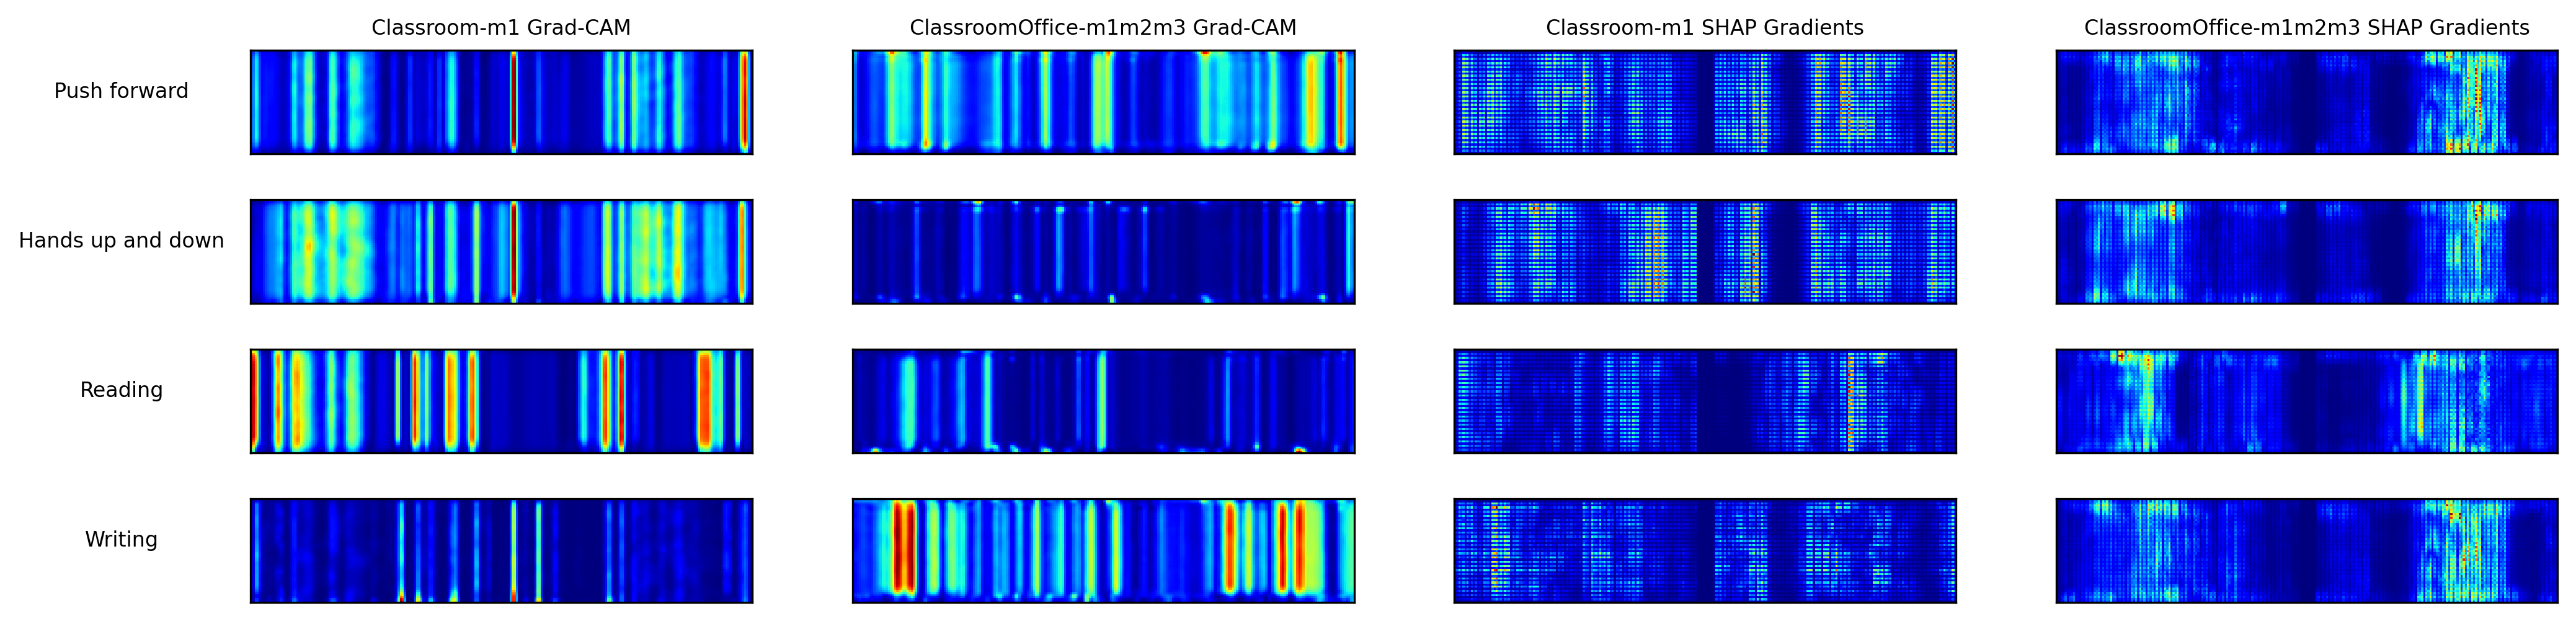

In [24]:
rows = len(activities.keys())
cols = 4

# create subplots
fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows), dpi=300)



for row_index in range(rows):
  label = list(activities.keys())[row_index]
  label_description = activities[label]
  print(f'Plotting Grad-CAM for label: {label_description}')
  
  subset = csv_merged.loc[(csv_merged['both_right_prediction']==True) & (csv_merged['label_m1']==label)]

  for model_index in range(len(models)):
    gradcam = cv2.resize(np.mean(data[model_index]['gradcam'][subset['gradcam_index']], axis=0), (242,50))
    axs[row_index, model_index].imshow(gradcam, cmap='jet')
    # axs[row_index, model_index].axis('off')

    shap_gradients = np.mean(np.abs(data[model_index]['shap_gradients'][subset['gradcam_index']]).sum(axis=-1), axis=0)
    axs[row_index, model_index+2].imshow(shap_gradients, cmap='jet')
    # axs[row_index, model_index+2].axis('off')

  if row_index == 0:
    axs[row_index, 0].set_title('Classroom-m1 Grad-CAM', fontsize=8)
    axs[row_index, 1].set_title('ClassroomOffice-m1m2m3 Grad-CAM', fontsize=8)
    axs[row_index, 2].set_title('Classroom-m1 SHAP Gradients', fontsize=8)
    axs[row_index, 3].set_title('ClassroomOffice-m1m2m3 SHAP Gradients', fontsize=8)

  axs[row_index, 0].set_ylabel(label_description, fontsize=8, rotation=0, labelpad=50)
  axs[row_index, 0].set_xticks([])
  axs[row_index, 0].set_yticks([])
  axs[row_index, 1].set_xticks([])
  axs[row_index, 1].set_yticks([])
  axs[row_index, 2].set_xticks([])
  axs[row_index, 2].set_yticks([])
  axs[row_index, 3].set_xticks([])
  axs[row_index, 3].set_yticks([])  

  plt.savefig(f'../Output/CompareFineGrainedModelsSingleVsMultipleWithSHAP/gradcam_and_shap_gradients.png', bbox_inches='tight', dpi=300)


---- 
# t-SNE and UMAP of GradCams


In [25]:
# Constants

# Correct predictions
right1 = data[0]['csv'].loc[data[0]['csv']['right_prediction'] == True]
right2 = data[1]['csv'].loc[data[1]['csv']['right_prediction'] == True]

# Add GradCam indexes
right1.reset_index(inplace=True)
right1.rename(columns={'index': 'gradcam_index'}, inplace=True)
right2.reset_index(inplace=True)
right2.rename(columns={'index': 'gradcam_index'}, inplace=True)

# GradCam heatmaps
gradcam1 = data[0]['gradcam']
gradcam2 = data[1]['gradcam']
# SHAP Gradients heatmaps
shap_gradients1 = data[0]['shap_gradients']
shap_gradients2 = data[1]['shap_gradients']
# Embeddings
embeddings1 = data[0]['embeddings']
embeddings2 = data[1]['embeddings']

/tmp/ipykernel_1200280/943553993.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right1.rename(columns={'index': 'gradcam_index'}, inplace=True)
/tmp/ipykernel_1200280/943553993.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right2.rename(columns={'index': 'gradcam_index'}, inplace=True)


In [27]:
def plot_tsne(subset, gradcam, title='', output_file=None, perplexity=30):
  X = gradcam[subset['gradcam_index'], :].reshape(len(subset), -1)

  labels = subset['label'].tolist()
  label_encoder = LabelEncoder()
  numeric_labels = label_encoder.fit_transform(labels)
  class_names = label_encoder.classes_
  class_names = np.array([activities[classname] for classname in class_names ])

  colormap = 'tab10'
  cmap = plt.get_cmap(colormap, len(class_names))

  tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
  X_embedded = tsne.fit_transform(X)
  x, y = X_embedded[:, 0], X_embedded[:, 1]

  fig, ax = plt.subplots(1, 2, figsize=(14, 6))
  ax[0].scatter(x, y, c=numeric_labels, cmap=cmap, s=5)
  ax[0].set_title(title)
  ax[0].set_xlabel('t-SNE Component 1')
  ax[0].set_ylabel('t-SNE Component 2')
  ax[0].grid(True)

  # Polar
  r = np.sqrt(x**2 + y**2)
  theta = np.arctan2(y, x)
  ax[1].scatter(theta, r, c=numeric_labels, cmap=colormap, s=5)
  ax[1].set_title(f'{title} (polar)')
  ax[1].set_xlabel('radius')
  ax[1].set_ylabel('theta')

  plt.tight_layout()

  legend_handles = []
  for i, class_name in enumerate(class_names):
      # Use the same cmap to get the color for each class
      color = cmap(i)
      legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=class_name,
                                      markersize=10, markerfacecolor=color))

  plt.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=8)


  if output_file is not None:
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
  plt.show()


def plot_umap(subset, gradcam, title='', output_file=None, n_neighbors=15, min_dist=0.1, low_memory=False):
  X = gradcam[subset['gradcam_index'], :].reshape(len(subset), -1)

  labels = subset['label'].tolist()

  label_encoder = LabelEncoder()
  numeric_labels = label_encoder.fit_transform(labels)
  class_names = label_encoder.classes_
  class_names = np.array([activities[classname] for classname in class_names ])

  mapper = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, low_memory=low_memory).fit(X)
  umap.plot.points(mapper, labels=class_names[numeric_labels], cmap='tab10')
  plt.title(title)
  if output_file is not None:
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
  



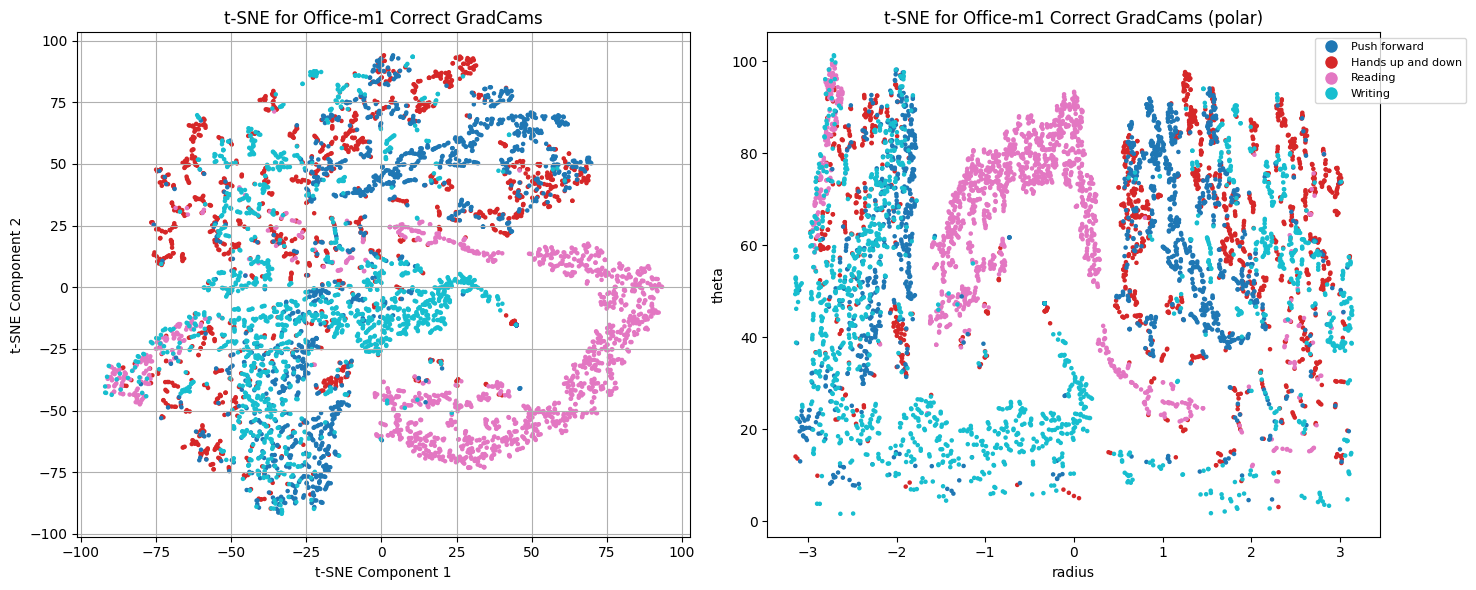

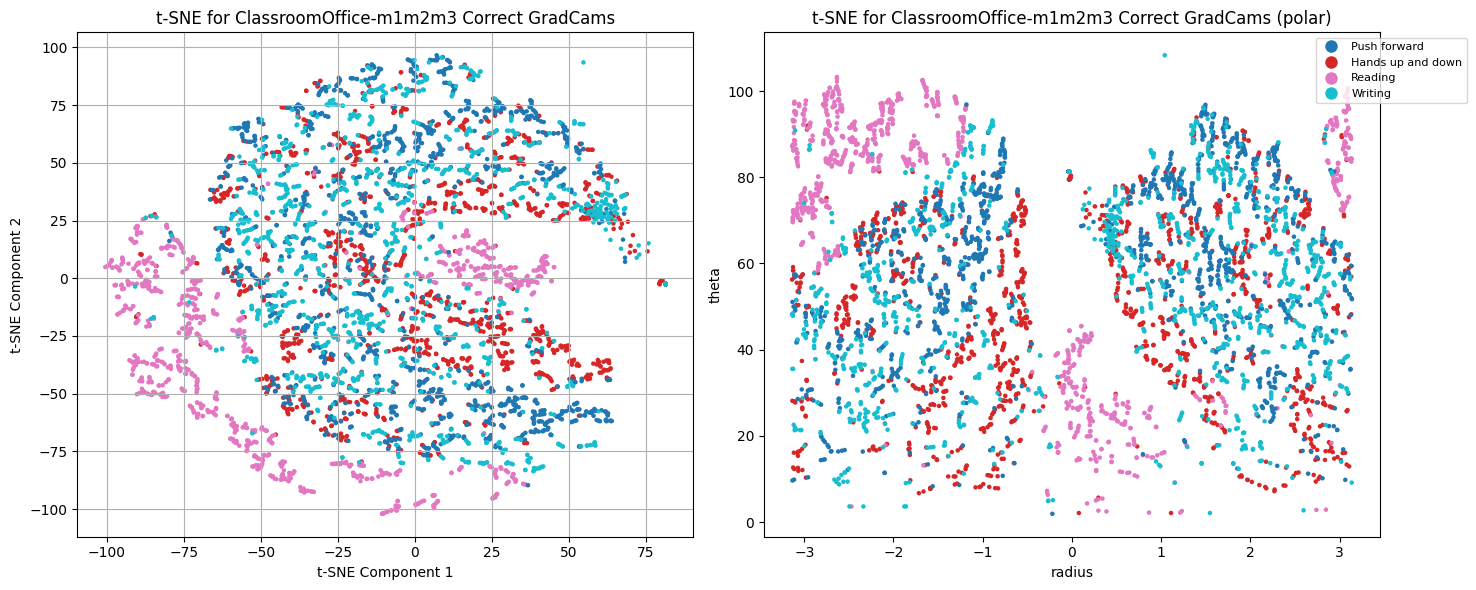

/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


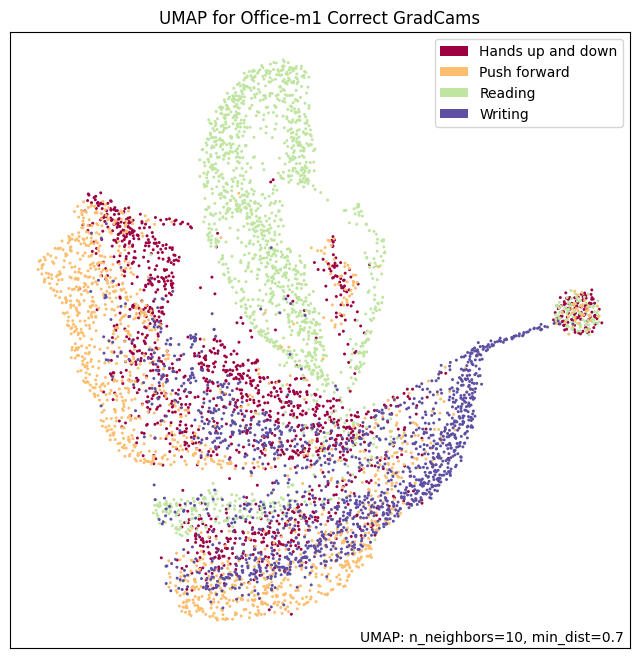

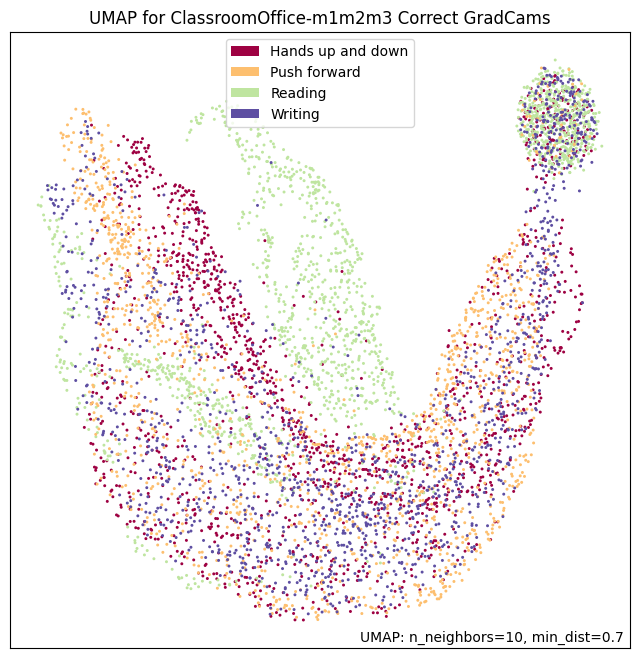

In [28]:
plot_tsne(right1, gradcam1, title='t-SNE for Office-m1 Correct GradCams', perplexity=5, output_file=f'{ROOT_DIR}/tsne_Office_m1_correct_gradcam.png')
plot_tsne(right2, gradcam2, title='t-SNE for ClassroomOffice-m1m2m3 Correct GradCams', perplexity=5, output_file=f'{ROOT_DIR}/tsne_ClassroomOffice_m1m2m3_correct_gradcam.png')
plot_umap(right1, gradcam1, title='UMAP for Office-m1 Correct GradCams', n_neighbors=10, min_dist=0.7, output_file=f'{ROOT_DIR}/umap_Office_m1_correct_gradcam.png')
plot_umap(right2, gradcam2, title='UMAP for ClassroomOffice-m1m2m3 Correct GradCams', n_neighbors=10, min_dist=0.7, output_file=f'{ROOT_DIR}/umap_ClassroomOffice_m1m2m3_correct_gradcam.png')

----
# t-SNE and UMAP of SHAP

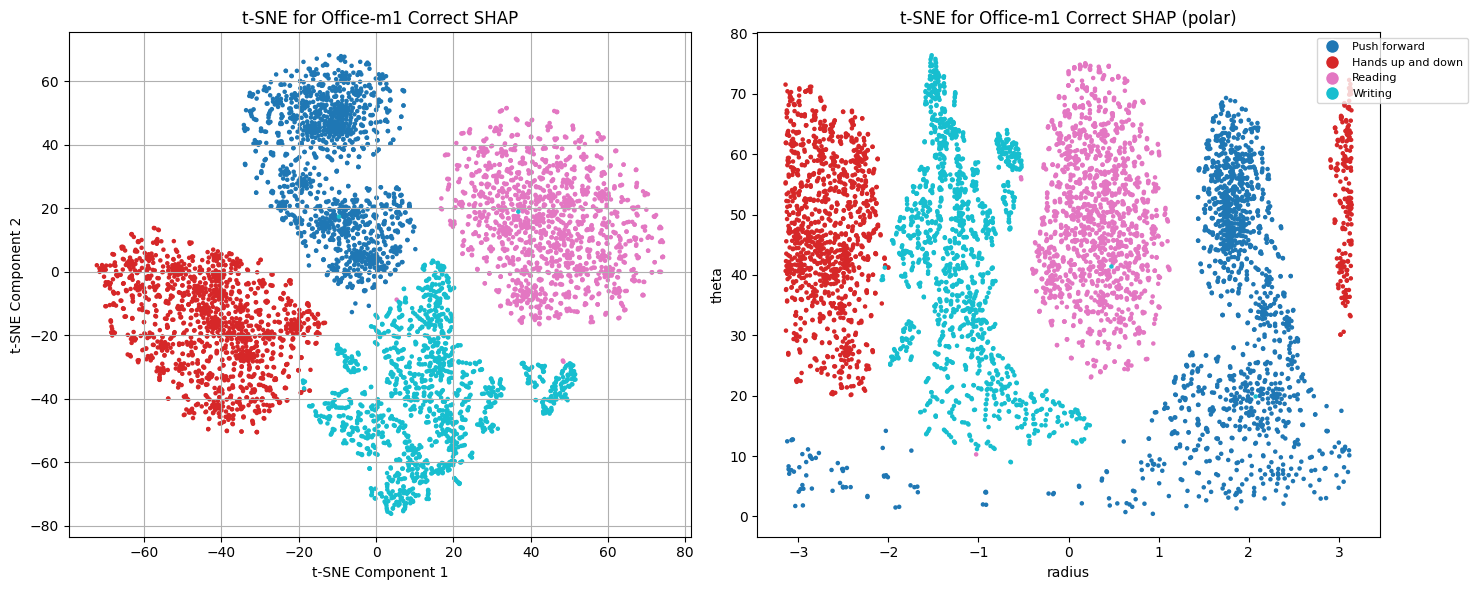

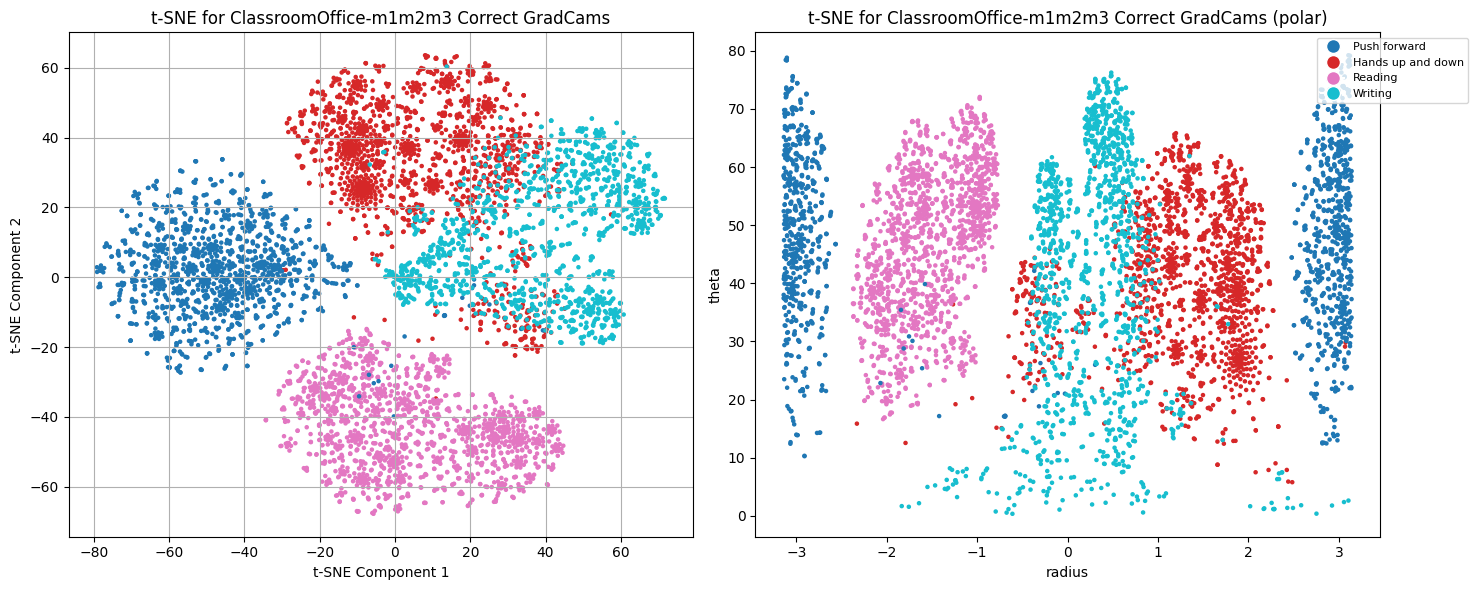

/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


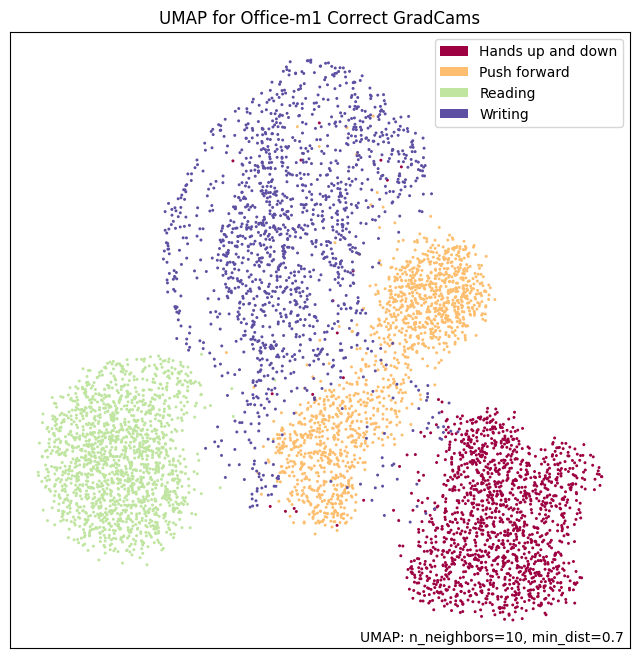

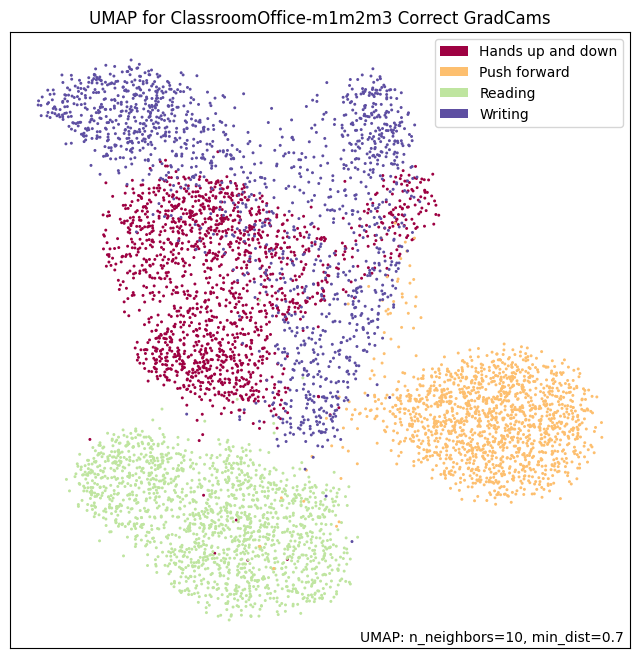

In [30]:
plot_tsne(right1, shap_gradients1, title='t-SNE for Office-m1 Correct SHAP', perplexity=5, output_file=f'{ROOT_DIR}/tsne_Office_m1_correct_SHAP.png')
plot_tsne(right2, shap_gradients2, title='t-SNE for ClassroomOffice-m1m2m3 Correct GradCams', perplexity=5, output_file=f'{ROOT_DIR}/tsne_ClassroomOffice_m1m2m3_correct_gradcam.png')
plot_umap(right1, shap_gradients1, title='UMAP for Office-m1 Correct GradCams', n_neighbors=10, min_dist=0.7, output_file=f'{ROOT_DIR}/umap_Office_m1_correct_gradcam.png')
plot_umap(right2, shap_gradients2, title='UMAP for ClassroomOffice-m1m2m3 Correct GradCams', n_neighbors=10, min_dist=0.7, output_file=f'{ROOT_DIR}/umap_ClassroomOffice_m1m2m3_correct_gradcam.png')

----
# t-SNE and UMAP of Embeddings


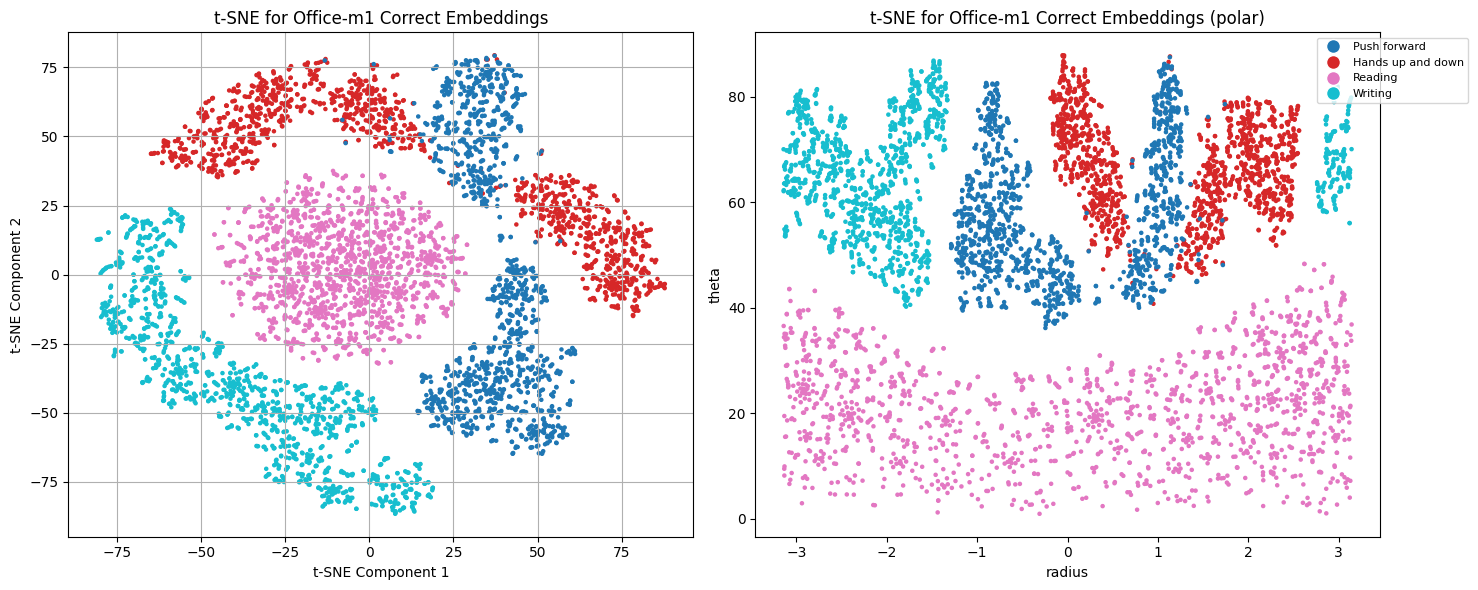

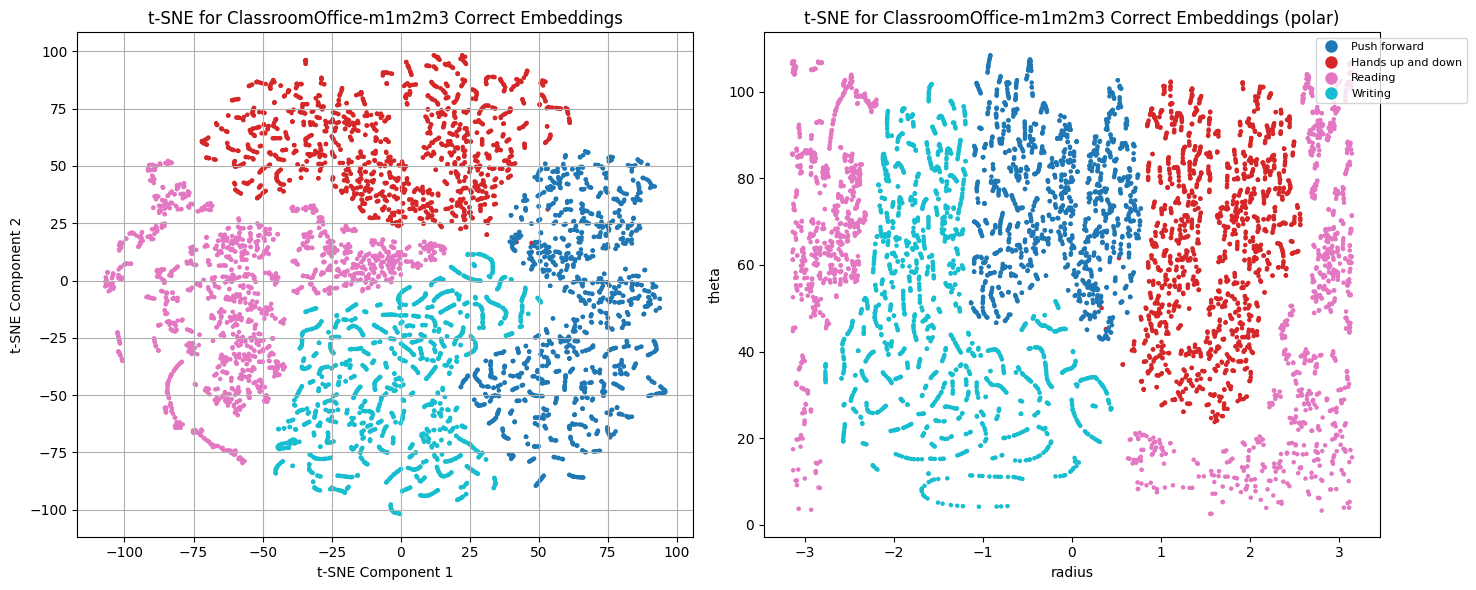

/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


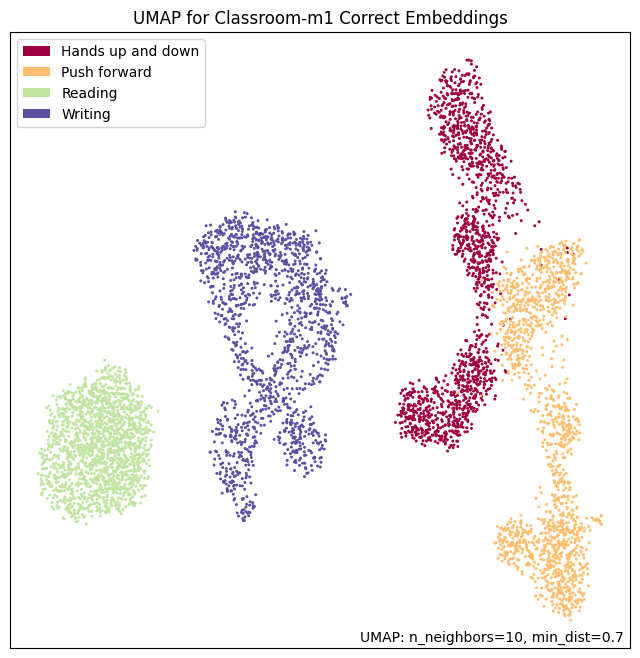

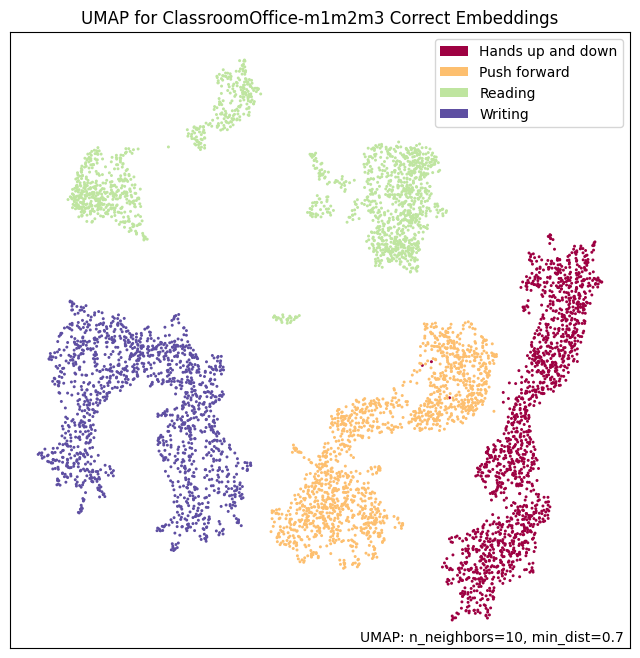

In [31]:
plot_tsne(right1, embeddings1, title='t-SNE for Office-m1 Correct Embeddings', perplexity=5, output_file=f'{ROOT_DIR}/tsne_Office_m1_correct_embeddings.png')
plot_tsne(right2, embeddings2, title='t-SNE for ClassroomOffice-m1m2m3 Correct Embeddings', perplexity=5, output_file=f'{ROOT_DIR}/tsne_ClassroomOffice_m1m2m3_correct_embeddings.png')
plot_umap(right1, embeddings1, title='UMAP for Classroom-m1 Correct Embeddings', n_neighbors=10, min_dist=0.7, output_file=f'{ROOT_DIR}/umap_Office_m1_correct_embeddings.png', low_memory=True)
plot_umap(right2, embeddings2, title='UMAP for ClassroomOffice-m1m2m3 Correct Embeddings', n_neighbors=10, min_dist=0.7, output_file='../Output/CompareFineGrainedModelsSingleVsMultiple/umap_ClassroomOffice_m1m2m3_correct_embeddings.png', low_memory=True)